# Model with Pytorch (Train on the GPU)

In [1]:
from functions import *

In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import string
import matplotlib.pyplot as plt

In [3]:
# Vérifiez si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilisé :", device)

Appareil utilisé : cuda


### create a class for the dataset

In [4]:
# Chargement des données
dataset = CaptchaDataset(file_path="data/6_CHARACTERS", size_image=(75, 250, 1), ncharacter_per_image=6, ncharacter_total=36)

train_size = len(dataset) - 11600
test_size = 11600
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## First model

### Create a model

In [6]:
# Création du modèle
model_v4 = CaptchaModel(size_image=(75, 250, 1), n_characters_per_image=6, n_characters_total=36, dropout_val=0.8)
model_v4.to(device)  # Transférez le modèle sur le GPU
criterion = nn.BCELoss()
optimizer = optim.Adam(model_v4.parameters(), lr=0.001)

### train the model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v4.to(device)
# Listes pour stocker les pertes
train_losses = []
val_losses = []

# Entraînement
num_epochs = 40
for epoch in range(num_epochs):
    model_v4.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # put the image and the label on the gpu
        images = images.to(device)
        labels  = labels.to(device)

        optimizer.zero_grad()
        outputs = model_v4(images)
        loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model_v4.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels  = labels.to(device)
            
            outputs = model_v4(images)
            loss = sum(criterion(output, label) for output, label in zip(outputs, labels.permute(1, 0, 2)))
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [1/40], Train Loss: 1.1765, Val Loss: 0.7224
Epoch [2/40], Train Loss: 0.9171, Val Loss: 0.7041
Epoch [3/40], Train Loss: 0.8467, Val Loss: 0.6648
Epoch [4/40], Train Loss: 0.7774, Val Loss: 0.6125
Epoch [5/40], Train Loss: 0.6949, Val Loss: 0.5266
Epoch [6/40], Train Loss: 0.6139, Val Loss: 0.4525
Epoch [7/40], Train Loss: 0.5406, Val Loss: 0.3836
Epoch [8/40], Train Loss: 0.4826, Val Loss: 0.3309
Epoch [9/40], Train Loss: 0.4372, Val Loss: 0.2966
Epoch [10/40], Train Loss: 0.4060, Val Loss: 0.2734
Epoch [11/40], Train Loss: 0.3812, Val Loss: 0.2532
Epoch [12/40], Train Loss: 0.3622, Val Loss: 0.2364
Epoch [13/40], Train Loss: 0.3458, Val Loss: 0.2209
Epoch [14/40], Train Loss: 0.3329, Val Loss: 0.2117
Epoch [15/40], Train Loss: 0.3217, Val Loss: 0.2016
Epoch [16/40], Train Loss: 0.3143, Val Loss: 0.1966
Epoch [17/40], Train Loss: 0.3079, Val Loss: 0.1928
Epoch [18/40], Train Loss: 0.3023, Val Loss: 0.1903
Epoch [19/40], Train Loss: 0.2959, Val Loss: 0.1860
Epoch [20/40], Train 

In [8]:
torch.save(model_v4, "model/model_full_v4.pth")

### plot the loss function

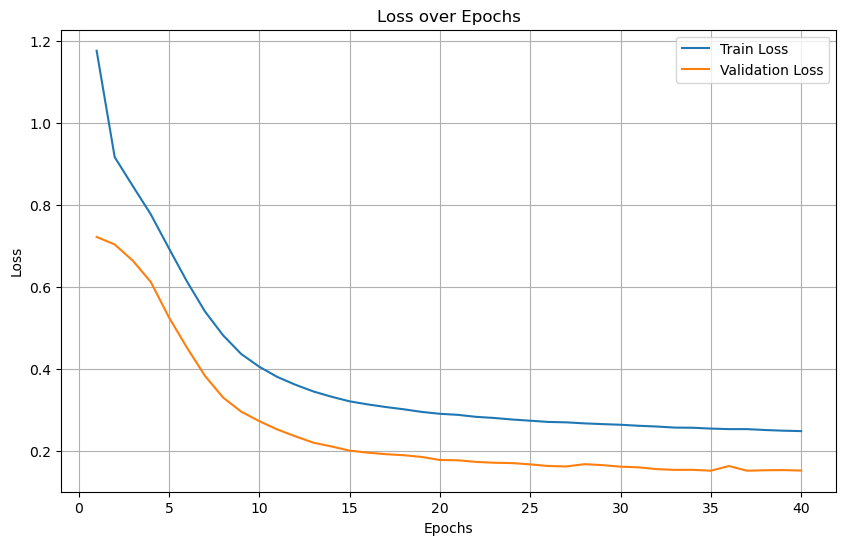

In [9]:
# Tracé des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
model_v4 = torch.load("model/model_full_v4.pth")
model_v4.eval()

C:\Users\Nasir\AppData\Local\Temp\ipykernel_5432\2419149204.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v4 = torch.load("model/model_full_v4.pth")


CaptchaModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=8928, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.8, inplace=False)
      (3): Linear(in_features=64, out_features=36, bias=True)
      (4): Sigmoid()
    )
  )
)

### Test the model on the test dataset

In [13]:
characters = string.ascii_uppercase + string.digits
model_v4.eval()
truepos = 0
count_img = 0
for images, labels in test_dataset:
    # print(images.shape)
    # print(labels.shape)
    # print(images)
    # print(model(images.unsqueeze(0)))
    images = images.to(device)
    labels = labels.to(device)
    prediction = predict_1(model_v4, images)
    
    labels = [characters[torch.argmax(la).item()] for la in labels]
    if sum(p == g for p, g in zip(prediction, labels)) != 6:
        count_img += 1
    #     print(prediction)
    #     print(labels)
    truepos += sum(p == g for p, g in zip(prediction, labels))
    

Accuracy = truepos/(len(test_dataset)*6)
Accuracy_v1 = (len(test_dataset)-count_img)/len(test_dataset)

In [14]:
print(f"l'accuracy sur les caractères est de {Accuracy}")
print(f"le nombre d'image qui ont au moins un caractère incorrect est de {count_img}") #count_img
print(f"l'autre accuracy sur les images est de {Accuracy_v1}") 

l'accuracy sur les caractères est de 0.9292672413793104
le nombre d'image qui ont au moins un caractère incorrect est de 2681
l'autre accuracy sur les images est de 0.7688793103448276
